In [47]:
import numpy as np 
import cupy as cp
import scipy.io as sio 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import seaborn as sns 
sns.set_theme()

In [48]:
def to_GPU(arr):
    return cp.array(arr)

def to_CPU(arr):
    return cp.asnumpy(arr)

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

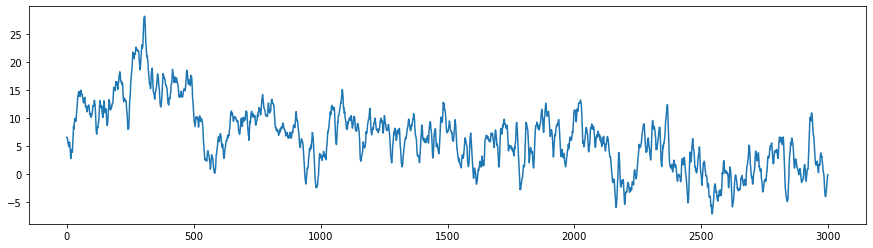

In [3]:
origin_datasets = sio.loadmat('/home/oneran/机器学习课设/BCI/Competition_train.mat')
X = origin_datasets['X']
Y = origin_datasets['Y']
Y = (Y+1) // 2

plt.figure(figsize=(15, 4))
plt.plot(np.arange(3000), X[0, 0, :])

In [4]:
from matplotlib.mlab import psd
target_freq = []
for i, sample in enumerate(X):
    sample_freq = []
    for j, channel in enumerate(sample):
        sample_freq.append(psd(channel, Fs=1000)[0])
    target_freq.append(sample_freq)
target_freq = np.array(target_freq)

## 提取出 3-30HZ 之间的脑电功率


In [5]:
psd_hz_3_to_30 = target_freq[:, :, 1:9]
psd_hz_3_to_30 = psd_hz_3_to_30.reshape(len(psd_hz_3_to_30), -1)
print(psd_hz_3_to_30.shape)

(278, 512)


## 标准缩放一下


In [6]:
def standard_scale(data):
    mean = np.mean(data, axis=1)
    std = np.std(data, axis=1) 
    data = (data.T - mean) / std
    data = data.T 
    return data 
def max_min_scale(data):
    max_n = np.max(data, axis=0)
    min_n = np.min(data, axis=0)
    data = (data - min_n) / (max_n - min_n)
    return data

## 就用神经网络进行分类吧


In [7]:
import os, sys 
sys.path.append('/home/oneran/机器学习课设/cifar-10/Photon')
from layers import * 
from optimizers import * 
from utils import * 

## LDA 进行分类


In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
stds = np.std(psd_hz_3_to_30, axis=0)
stds = stds.reshape(64, -1)
max_std = np.max(stds, axis=0)
min_std = np.min(stds, axis=0) 
print(max_std.shape, min_std.shape)
standard_sclaed_std = (stds - min_std) / (max_std - min_std)
print(standard_sclaed_std.shape)

(8,) (8,)
(64, 8)


[ 0  1  9  2 32 55 48  7 56 54 47 10 34  3  4 46 62 40 19 57 33 17 23 26
 44 36  5 41 45 18 49 11 58 30 42 35 12 16 39 31 61 14  6 27 13 15 50 20
 24 63  8 43 53 29 22 28 38 21 51 52 25 37 59 60]


/tmp/ipykernel_3102/1253725977.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.bar(sorted_channel_index.astype(np.str), channel_score[sorted_channel_index] / np.max(channel_score))
/tmp/ipykernel_3102/1253725977.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(sorted_channel_index.astype(np.str), [0.5] * 64, color='r')


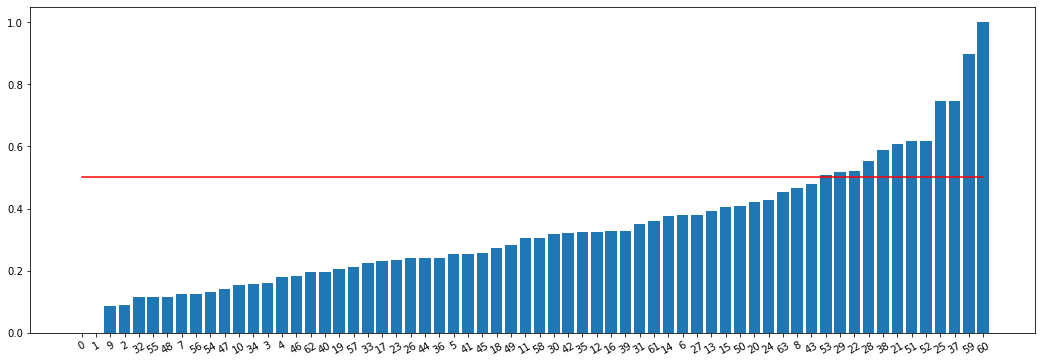

In [9]:
channel_score = np.sum(standard_sclaed_std, axis=1)
sorted_channel_index = channel_score.argsort()
plt.figure(figsize=(18, 6))
plt.bar(sorted_channel_index.astype(np.str), channel_score[sorted_channel_index] / np.max(channel_score))
plt.plot(sorted_channel_index.astype(np.str), [0.5] * 64, color='r')
plt.xticks(rotation=30)
print(sorted_channel_index)

In [10]:
selected_channel = np.where((channel_score/ np.max(channel_score)) >= 0.7)[0]
print('所选择的电极通道是: {}'.format(selected_channel))
# selected_channel = np.arange(64, dtype=np.int)

所选择的电极通道是: [25 37 59 60]


## 数据处理

In [11]:
standard_sclaed_data = standard_scale(psd_hz_3_to_30)
max_min_scaled_data = max_min_scale(standard_sclaed_data)
# seed = 20
seed = 20
X_train, X_test, Y_train, Y_test = train_test_split(max_min_scaled_data.reshape(len(max_min_scaled_data), 64, -1)[:, selected_channel, :].reshape(len(standard_sclaed_data), -1), Y, random_state=seed)
print(X_train.shape)

(208, 32)


## 且慢 在这之前 先用RBF进行分类

In [35]:
sys.path.append('/home/oneran/机器学习课设/BCI')
from RBF_CPU import * 
from tensorflow.keras.utils import to_categorical
Y_train_ = to_categorical(Y_train)
RBF_model = RBF(96)
RBF_model.fit(X_train, Y_train_, 5000)
print('Train:', np.mean(np.argmax(RBF_model.predict(X_train), axis=1) == Y_train.flatten()))
print('Test:',  np.mean(np.argmax(RBF_model.predict(X_test), axis=1) == Y_test.flatten()))

Finished initialized!
Finished clustering!


/home/oneran/机器学习课设/BCI/RBF_CPU.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cmax = np.array([[np.max(np.dot((self.cluster.cluster_centers_ - c).T, (self.cluster.cluster_centers_ - c))), c] for c in self.cluster.cluster_centers_])


Train: 0.7740384615384616
Test: 0.7571428571428571


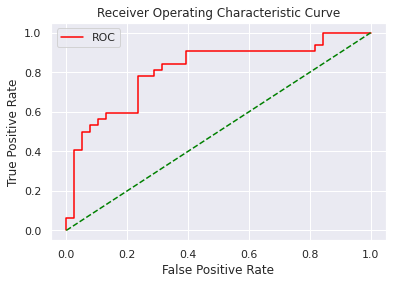

In [46]:
pred = RBF_model.predict(X_test)
fpr, tpr, thersholds = roc_curve(Y_test, pred[:, 1] / np.sum(pred, axis=1))
plot_roc_curve(fpr, tpr)

## 这里才是你们要的LDA

In [49]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, Y_train)
print(LDA.score(X_train, Y_train))
print(LDA.score(X_test, Y_test))

0.8269230769230769
0.8428571428571429


/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


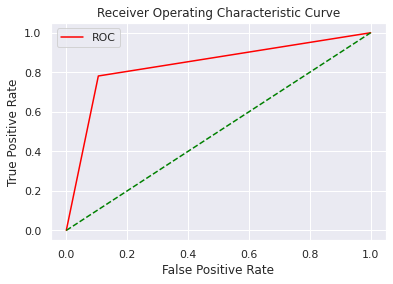

In [51]:
pred = LDA.predict(X_test)
fpr, tpr, thersholds = roc_curve(Y_test, pred)
plot_roc_curve(fpr, tpr)

Score: 0.8221153846153846
Score: 0.8285714285714286


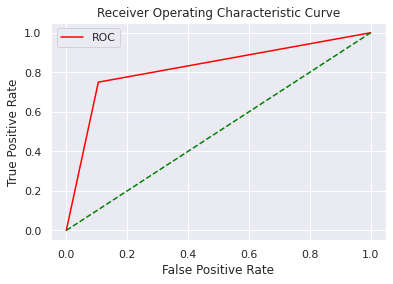

In [53]:
class LDA:
    def __init__(self):
        self.X = None 
        self.Y = None 
        self.w = None 
        self.c = None
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y.flatten()
        X_category_1 = X[np.where(self.Y == 0)]
        X_category_2 = X[np.where(self.Y == 1)]
        mean_1 = np.mean(X_category_1, axis=0)
        mean_2 = np.mean(X_category_2, axis=0)
        #* 这些都在GPU上

        mat_1 = to_GPU(X_category_1 - mean_1)
        mat_2 = to_GPU(X_category_2 - mean_2)

        corr_1 = cp.dot(mat_1.T, mat_1)
        corr_2 = cp.dot(mat_2.T, mat_2)
        Sw = corr_1 + corr_2
        Sw_inverse = cp.linalg.pinv(Sw)
        self.w = np.dot(to_CPU(Sw_inverse), (mean_1 - mean_2))
        #* c1 -> 0  c2 -> 1
        self.c = np.array([np.dot(self.w.T, mean_1), np.dot(self.w.T, mean_2)])
        return self.score(self.X, self.Y)

    def predict(self, X):
        proj = np.dot(X, self.w)
        proj = np.stack([proj, proj], -1)
        ans = np.argmin((proj - self.c) ** 2, axis=1)
        return ans 
    
    def score(self, X, Y):
        score = np.mean(self.predict(X) == Y)
        print('Score: {}'.format(score))
        return score

lda = LDA()
lda.fit(X_train, Y_train)
lda.score(X_test, Y_test.flatten())

pred = lda.predict(X_test)
fpr, tpr, thersholds = roc_curve(Y_test, pred)
plot_roc_curve(fpr, tpr)

## 搭建神经网络


In [ ]:
from collections import OrderedDict
import cupy as cp

class Net:
    def __init__(self): 
        self.model = self.build_model()
        self.batch_size = 20
        self.optimizer = SGD(208 // self.batch_size, lr=0.01, momentum=0.8)
        #* datas[0] -> X datas[1] -> Y
        self.datas = None 
        self.evaluate_data = None
        self.history = []

    def train(self, epochs=20):
        self.optimizer.all_epochs = epochs
        for epoch in range(epochs):
            losses = 0
            for steps in range(len(self.datas[0]) // self.batch_size):
                grads, loss = self.cal_gradient(to_GPU(self.datas[0][steps * self.batch_size: (steps + 1) * self.batch_size]), to_GPU(self.datas[1][steps * self.batch_size: (steps + 1) * self.batch_size]))
                self.fit(grads)
                if steps % 10 == 0:
                    print('Epoch: {} Step: {} Loss: {}'.format(epoch, steps+1, cp.mean(loss)))
                    self.call_evaluate(self.evaluate_data[0], self.evaluate_data[1])
                    self.history.append(np.mean(to_CPU(loss)))


    def predict(self, x, train=True):
        if train:
            for layer in self.layers.values():
                x = layer.forward(x.copy())
        else:
            for layer in self.layers.values():
                if isinstance(layer, BatchNormalization) or isinstance(layer, Dropout):
                    x = layer.forward(x.copy(), False)
                else:
                    x = layer.forward(x.copy())

        return x 
    
    def cal_loss(self, x, y):
        y_out = self.predict(x)
        loss = self.output.forward(y_out, y)
        return loss 

    def cal_gradient(self, x, y):
        loss = self.cal_loss(x, y)

        dout = self.output.backward()
        for layer in list(self.layers.values())[::-1]:
            dout = layer.backward(dout) 
        
        grads = {}
        for name, value in self.paramized_layers_name.items():
            grads['W_{}'.format(name)] = self.layers[list(self.layers.keys())[value-1]].dW 
            grads['b_{}'.format(name)] = self.layers[list(self.layers.keys())[value-1]].db 

        return grads, loss
    
    def fit(self, grads):
        self.optimizer.process(self.params, grads)


    def build_model(self):
        '''
        网络架构
        Dense   1 
        BN      2
        ReLU    3
        Dropout 4

        Dense   5
        BN      6
        ReLU    7
        Dropout 8

        Dense   9
        BN      10
        ReLU    11
        Dropout 12

        Dense   13
        BN      14
        ReLU    15
        Dropout 16

        Dense   17
        BN      18
        ReLU    19
        Dropout 20

        Dense   21
        output
        
        '''
        self.paramized_layers_name = {
            'affine_1': 1,
            'affine_2': 5,
            'affine_3': 9,
            # 'affine_4': 13,
            # 'affine_5': 17,
            # 'affine_6': 21
            }
        self.layers = OrderedDict()
        self.params = {}
        #* ============================================================Dense 1
        self.params['W_affine_1'] = self.HeInit((32, 64), 32)
        self.params['b_affine_1'] = cp.zeros((64))
        self.layers['affine_1'] = Affine(self.params['W_affine_1'], self.params['b_affine_1'])
        self.layers['bn_1'] = BatchNormalization(1, 0)
        self.layers['relu_1'] = ReLU()
        self.layers['dropout_1'] = Dropout(0.5)
        #* ============================================================Dense 2
        self.params['W_affine_2'] = self.HeInit((64, 128), 64)
        self.params['b_affine_2'] = cp.zeros((128))
        self.layers['affine_2'] = Affine(self.params['W_affine_2'], self.params['b_affine_2'])
        self.layers['bn_2'] = BatchNormalization(1, 0)
        self.layers['relu_2'] = ReLU()
        self.layers['dropout_2'] = Dropout(0.5)
        # #* ============================================================Dense 3
        # self.params['W_affine_3'] = self.HeInit((64, 64), 64)
        # self.params['b_affine_3'] = cp.zeros((64))
        # self.layers['affine_3'] = Affine(self.params['W_affine_3'], self.params['b_affine_3'])
        # self.layers['bn_3'] = BatchNormalization(1, 0)
        # self.layers['relu_3'] = ReLU()
        # self.layers['dropout_3'] = Dropout(0.3)
        # #* ============================================================Dense 4
        # self.params['W_affine_4'] = self.HeInit((64, 64), 64)
        # self.params['b_affine_4'] = cp.zeros((64))
        # self.layers['affine_4'] = Affine(self.params['W_affine_4'], self.params['b_affine_4'])
        # self.layers['bn_4'] = BatchNormalization(1, 0)
        # self.layers['relu_4'] = ReLU()
        # self.layers['dropout_4'] = Dropout(0.3)
        # #* ============================================================Dense 5
        # self.params['W_affine_5'] = self.HeInit((64, 64), 64)
        # self.params['b_affine_5'] = cp.zeros((64))
        # self.layers['affine_5'] = Affine(self.params['W_affine_5'], self.params['b_affine_5'])
        # self.layers['bn_5'] = BatchNormalization(1, 0)
        # self.layers['relu_5'] = ReLU()
        # self.layers['dropout_5'] = Dropout(0.3)
        #* ============================================================Output
        self.params['W_affine_3'] = self.HeInit((128, 2), 128)
        self.params['b_affine_3'] = cp.zeros((2))
        self.layers['affine_3'] = Affine(self.params['W_affine_3'], self.params['b_affine_3'])
        self.output = SoftmaxLossLayer()
    
    def call_evaluate(self, X, Y):
        print('Score: {}'.format(np.mean(np.argmax(to_CPU(self.predict(to_GPU(X), False)), axis=1) == np.argmax(Y, axis=1))))

    def XavierInit(self, shape):
        return cp.random.rand(*shape) 

    def HeInit(self, shape, nodes_num): 
        return cp.random.rand(*shape) * cp.sqrt(2. / nodes_num) * 0.01


In [ ]:
from tensorflow.keras.utils import to_categorical
model = Net()
Y_train_ = to_categorical(Y_train, 2)
model.datas = [X_train, Y_train_]
model.evaluate_data = [X_test, to_categorical(Y_test)]

In [ ]:
model.train(300)

Epoch: 0 Step: 1 Loss: 0.48521471512310727
Score: 0.4857142857142857
Epoch: 1 Step: 1 Loss: 0.4568084207561802
Score: 0.5
Epoch: 2 Step: 1 Loss: 0.4488008408829266
Score: 0.5714285714285714
Epoch: 3 Step: 1 Loss: 0.43218929928717564
Score: 0.4857142857142857
Epoch: 4 Step: 1 Loss: 0.4200517423464395
Score: 0.5857142857142857
Epoch: 5 Step: 1 Loss: 0.434142663449368
Score: 0.5714285714285714
Epoch: 6 Step: 1 Loss: 0.4815815764505774
Score: 0.6
Epoch: 7 Step: 1 Loss: 0.7328564165976195
Score: 0.5714285714285714
Epoch: 8 Step: 1 Loss: 0.4733895906807641
Score: 0.5428571428571428
Epoch: 9 Step: 1 Loss: 0.35347774745466076
Score: 0.5285714285714286
Epoch: 10 Step: 1 Loss: 0.515065431081241
Score: 0.5142857142857142
Epoch: 11 Step: 1 Loss: 0.5185156449482904
Score: 0.5142857142857142
Epoch: 12 Step: 1 Loss: 0.34848449178073826
Score: 0.5142857142857142
Epoch: 13 Step: 1 Loss: 0.5199678771023255
Score: 0.5142857142857142
Epoch: 14 Step: 1 Loss: 0.44901663599436964
Score: 0.5857142857142857
Ep